In [375]:
#载入所需package
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping 
import cmath
from torch import nn
import random
from torch.utils import data
import copy
from scipy.special import kv
from scipy import integrate
import seaborn as sns
import matplotlib as mpl

## Original Generator(para to specific-frequency)

In [376]:
#标准 generator
class generator_t:
    def __init__(self,df,mu = 0, sigma = 1,samplesize = 1000, h = 0.01):
        self.df = df
        self.mu = mu
        self.sigma = sigma
        self.samplesize = samplesize
        self.frequency = h
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)
    
    def generate_standard_t(self):
        d0 = np.random.standard_t(self.df, (self.samplesize,1))
        d1 = self.cumulate(d0)
        delta = torch.tensor(d0)
        data = torch.tensor(d1)
        delta.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
        return delta,data

In [377]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = (math.sqrt(s**2+c**2))**h
                theta = math.atan(s/c)*h
                c_h = r*math.cos(theta)
                s_h = r*math.sin(theta)
                R = R+[c_h]
                R = R+[s_h]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    

In [378]:
class rejection_method:    
    def __init__(self,h,n,v,mu = 0,sigma = 1):        
        self.h = h
        self.v = v
        self.mu = mu
        self.sigma = sigma
        self.n = n
    def phi_h(self,t):
        phi_real = math.cos(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        phi_imag = math.sin(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        r = (math.sqrt(phi_real**2+phi_imag**2))**self.h
        theta = math.atan(phi_imag/phi_real)*self.h
        phi_real = r*math.cos(theta)
        phi_imag = r*math.sin(theta)
        phi_abs = math.sqrt(phi_real**2+phi_imag**2)
        return phi_real, phi_imag, phi_abs
    def f(self,x,t_lim=200,t_num=2000):
        t = torch.linspace(-int(t_lim),int(t_lim),t_num)
        intg = []
        #因为密度是real的
        for i in range(t_num):
            r = self.phi_h(t[i])[0]
            im = self.phi_h(t[i])[1]
            intg += [math.cos(t[i]*x)*r+math.sin(t[i]*x)*im]
        y = 1/(2*math.pi)*integrate.trapz(intg, t)
        return y
    def phi_abs0(self,t):
        return self.phi_h(t)[2]
    def phi_prime(self,t,delt = 0.01):
        d_1 = (self.phi_h(t)[0]-self.phi_h(t+delt)[0])/delt
        d_2 = (self.phi_h(t)[1]-self.phi_h(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2
    def phi_prime_prime(self,t,delt = 0.01):
        d_1 = (self.phi_prime(t)[0]-self.phi_prime(t+delt)[0])/delt
        d_2 = (self.phi_prime(t)[1]-self.phi_prime(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2,d_abs  
    def phi_abs2(self,t):
        return self.phi_prime_prime(t)[2]
    def integ(self,domain = 100,ndots = 500):
        t = torch.linspace(-int(domain),int(domain),ndots)
        intg_0 = []
        intg_2 = []
        for i in range(len(t)):
            intg_0 += [self.phi_abs0(t[i])]
        c = 1/(2*math.pi)*integrate.trapz(intg_0, t)
        for i in range(len(t)):
            intg_2 += [self.phi_abs2(t[i])]
        k = 1/(2*math.pi)*integrate.trapz(intg_2, t)
        return c,k
    def hat_function(self,x):        
        c,k = self.integ()
        g = min(c,k/(x**2))
        return g

    def genertator(self):
        total = 25*self.n
        V_1 = np.random.uniform(-1,1,total)
        V_2 = np.random.uniform(-1,1,total)
        c,k = self.integ()
        X = []
        for i in range(total):
            y = math.sqrt(k/c)*(V_1[i]/V_2[i])
            U = np.random.uniform(-1,1)            
            if len(X) >=self.n:
                break
                
            elif U<= (self.f(y)/self.hat_function(y)):
                X+=[y]
            else:
                continue
        return X
        
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)    

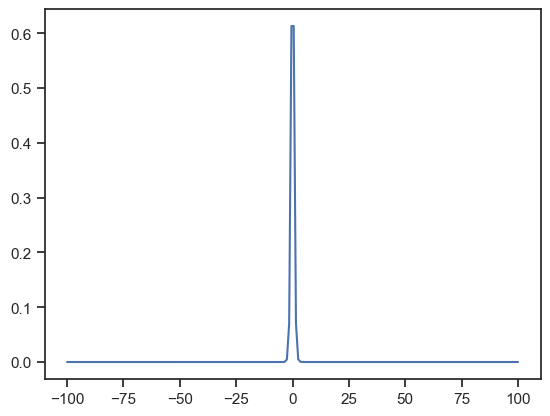

In [379]:
rm = rejection_method(h = 2,n = 1000,v =3)
num_t = 200
range_t = 100
t = torch.linspace(-range_t,range_t,num_t,dtype = torch.float64)
intg_0 = []
for i in range(len(t)):
    intg_0 += [rm.phi_abs0(t[i])]
plt.plot(t,intg_0)

In [380]:
x = rm.genertator()


In [381]:
X = torch.tensor(x)
x_show = []
for i in range(len(x)):
    if abs(x[i])<7:
        x_show+=[x[i]]
len(x_show)

939

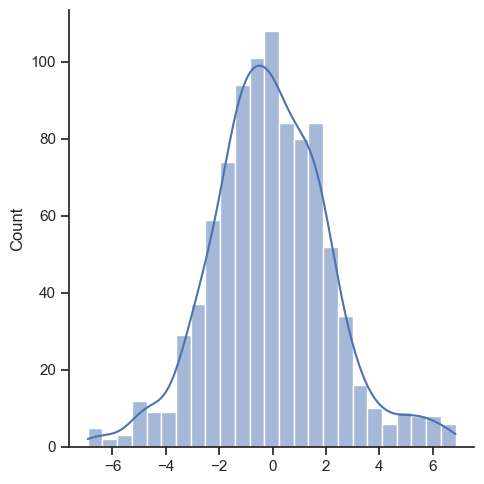

In [382]:
fig = sns.displot(data = x_show,kind = 'hist',kde = "TRUE")


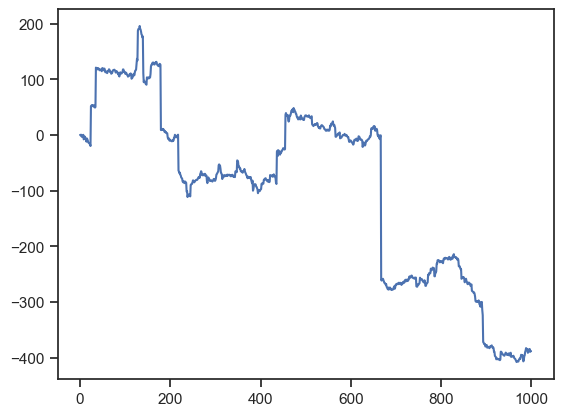

In [383]:
path = rm.cumulate(x)
plt.plot(path)

## frequency changing 

In [384]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t,h):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            r = math.sqrt(s**2+c**2)**h
            theta = math.atan(s/c)*h
            s = math.sin(theta)*r
            c = math.cos(theta)*r
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = math.sqrt(s**2+c**2)**h
                theta = math.atan(s/c)*h
                s = math.sin(theta)*r
                c = math.cos(theta)*r
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R


In [385]:
num_feature = 100
range_feature = 20
num_sample = 100
num_labels = num_t
total = num_sample*num_feature
#t = t.reshape((-1,len(t)))
feat = torch.linspace(-range_feature,range_feature,num_feature,dtype = torch.float64)

In [386]:
print(num_feature,range_feature,num_sample,num_labels,total,num_t,range_t)

100 20 100 200 10000 200 100


In [387]:
#实例化(V =3)
CF = Characteristic_function(x)
labels = CF.ecf_h(t,0.01)

In [388]:
a = []
features = []
label = []
for i in range(num_sample):
    label+=labels
    features+=feat


In [391]:
type(features)

list

In [392]:
labels =torch.tensor(label,dtype = torch.float64).reshape((-1,2*num_labels))
features = torch.tensor(features,dtype = torch.float64).reshape((-1,num_feature))

In [436]:
features.shape

torch.Size([100, 100])

In [394]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 1
D_loader = load_array((features,labels), batch_size)

In [437]:
next(iter(D_loader))[0].shape

torch.Size([1, 100])

In [397]:
# 初始化参数定义


hidden_2, hidden_3 = 256, 256

W1 = nn.Parameter(torch.randn(
    num_feature, hidden_2, requires_grad=True,dtype = torch.float64) * 0.01)
b1 = nn.Parameter(torch.zeros(hidden_2, requires_grad=True,dtype = torch.float64))

W2 = nn.Parameter(torch.randn(
    hidden_2, hidden_3, requires_grad=True,dtype = torch.float64) * 0.01)
b2 = nn.Parameter(torch.zeros(hidden_3, requires_grad=True,dtype = torch.float64))

W3 = nn.Parameter(torch.randn(
    hidden_3, num_feature, requires_grad=True,dtype = torch.float64) * 0.01)
b3 = nn.Parameter(torch.zeros(num_feature, requires_grad=True,dtype = torch.float64))


params = [W1, b1, W2, b2, W3, b3]

In [398]:
#激活函数
def relu(X):
    a = torch.zeros_like(X)
    b = torch.max(X, a)
    return torch.tensor(b,dtype = torch.float64)

In [420]:
len(t)

200

In [409]:
def expcostx(x,V):
    a = t.reshape((-1,1))@x.reshape((1,-1))
    b = (torch.cos(a)-1)@V.reshape((-1,1))
    c = torch.exp((range_feature*2/num_feature)*b)
    return c
def I(x):
    y = copy.deepcopy(x)
    y[abs(x)>1]=0
    return y
    
def realtx(x,V):
    x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.cos(a5)
    return a6
def imagetx(x,V):
    #x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.sin(a5)
    return a6

In [438]:
net_1(features[0]).shape

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x1000 and 100x1)

In [443]:
def realtx(x,V):
    x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.cos(a5)
    return a6
imagetx(features[0],net_2(features[0])).shape

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


torch.Size([200, 1])

In [466]:
def net_2(X):
    X_clone = X.clone()
    X = X.reshape((-1, num_feature))
    H1 = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H2 = relu(H1@W2 + b2)
    V = (H2@W3 + b3)
    R_1 = expcostx(X,V)*realtx(X,V)
    R_2 = expcostx(X,V)*imagetx(X,V)
    R = torch.cat((R_1,R_2),1).reshape((1,-1))
    return V

In [465]:
V = net_2(features[0])
realtx(x,V)

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


In [467]:
def net_1(X):
    X_clone = X.clone()
    X = X.reshape((-1, num_feature))
    H1 = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H2 = relu(H1@W2 + b2)
    V = (H2@W3 + b3)
    R_1 = expcostx(X,V)*realtx(X,V)
    R_2 = expcostx(X,V)*imagetx(X,V)
    R = torch.cat((R_1,R_2),1).reshape((1,-1))
    return R


In [468]:
H0 =  features[0].reshape((-1, num_feature))
H1 = relu(H0@W1 + b1)
H2 = relu(H1@W2 + b2)
V = (H2@W3 + b3)
a = t.reshape((-1,1))@features[0].reshape((-1,num_feature))

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)


In [469]:
loss = nn.MSELoss()

In [470]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [471]:
lr = 0.02
num_epochs = int(num_sample/batch_size)
net = net_1
loss = nn.MSELoss()

trainer = torch.optim.SGD(params, lr=0.03)

In [472]:
for epoch in range(num_epochs):
    for X, y in D_loader:
        l = loss(net_1(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(X), y)
    print(f'epoch {epoch + 1}, loss {l:f}')

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)
/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/1306561042.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype = torch.float64)


epoch 1, loss 0.441235
epoch 2, loss 0.462831
epoch 3, loss 0.461997
epoch 4, loss 0.461361
epoch 5, loss 0.460604
epoch 6, loss 0.459664
epoch 7, loss 0.458493
epoch 8, loss 0.457038
epoch 9, loss 0.459728
epoch 10, loss 0.460024
epoch 11, loss 0.460326
epoch 12, loss 0.460586
epoch 13, loss 0.460816
epoch 14, loss 0.461020
epoch 15, loss 0.461204
epoch 16, loss 0.461371
epoch 17, loss 0.461525
epoch 18, loss 0.461667
epoch 19, loss 0.461800
epoch 20, loss 0.461924
epoch 21, loss 0.462042
epoch 22, loss 0.462153
epoch 23, loss 0.462260
epoch 24, loss 0.462361
epoch 25, loss 0.462459
epoch 26, loss 0.462553
epoch 27, loss 0.462644
epoch 28, loss 0.462732
epoch 29, loss 0.462817
epoch 30, loss 0.462901
epoch 31, loss 0.462982
epoch 32, loss 0.463061
epoch 33, loss 0.463138
epoch 34, loss 0.463214
epoch 35, loss 0.463288
epoch 36, loss 0.463360
epoch 37, loss 0.463431
epoch 38, loss 0.463501
epoch 39, loss 0.463570
epoch 40, loss 0.463637
epoch 41, loss 0.463703
epoch 42, loss 0.463767
e

## visualized characteristic function(real)

In [476]:
net_1(features[0]).shape

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)
/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/1306561042.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype = torch.float64)


torch.Size([1, 400])

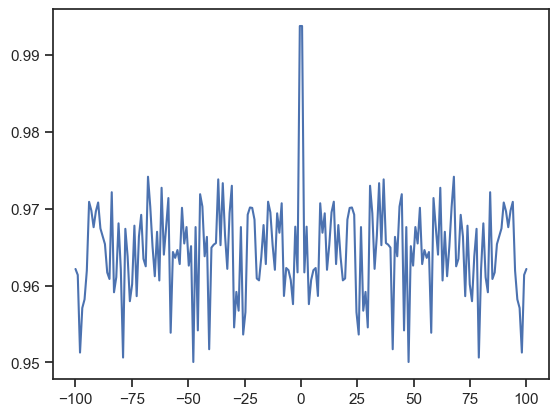

In [475]:
real = torch.zeros(int(len(labels[0])/2)+1)
image = torch.zeros(int(len(labels[0])/2)+1)
for i in range(len(labels[0])):
    if i%2 ==0:
        real[int(i/2)] = labels[0][i]
    else:
        image[int((i+1)/2)] = labels[0][i]
real = real[0:len(t)]
plt.plot(t,real)

In [477]:
predict0 = list(net_1(features[0]))

/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/2169779723.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)
/var/folders/ym/35040q6j5x912qskn704_hy80000gn/T/ipykernel_26788/1306561042.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype = torch.float64)


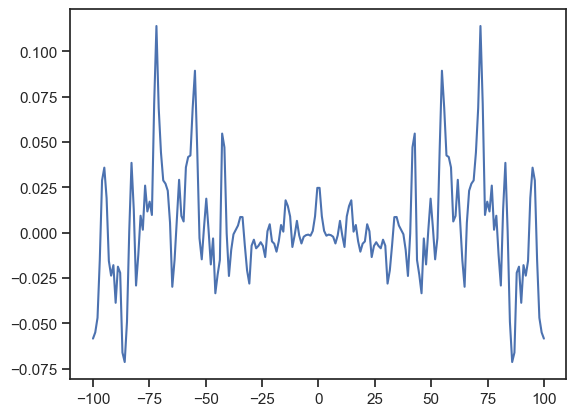

In [479]:
real_h = torch.zeros(int(len(labels[0])/2)+1)
image_h = torch.zeros(int(len(labels[0])/2)+1)
for i in range(len(labels[0])):
    if i%2 ==0:
        real_h[int(i/2)] = predict0[0][i]
    else:
        image_h[int((i+1)/2)] = predict0[0][i]
real_h = real_h[0:len(t)]        
plt.plot(t,real_h.detach().numpy())